In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [2]:
data = pd.read_csv('./input/data-category.txt')
data.head()

,Age,Sex,Income,Y
0,18,1,472,2
1,18,0,468,5
2,18,1,451,6
3,18,1,441,6
4,18,1,499,6


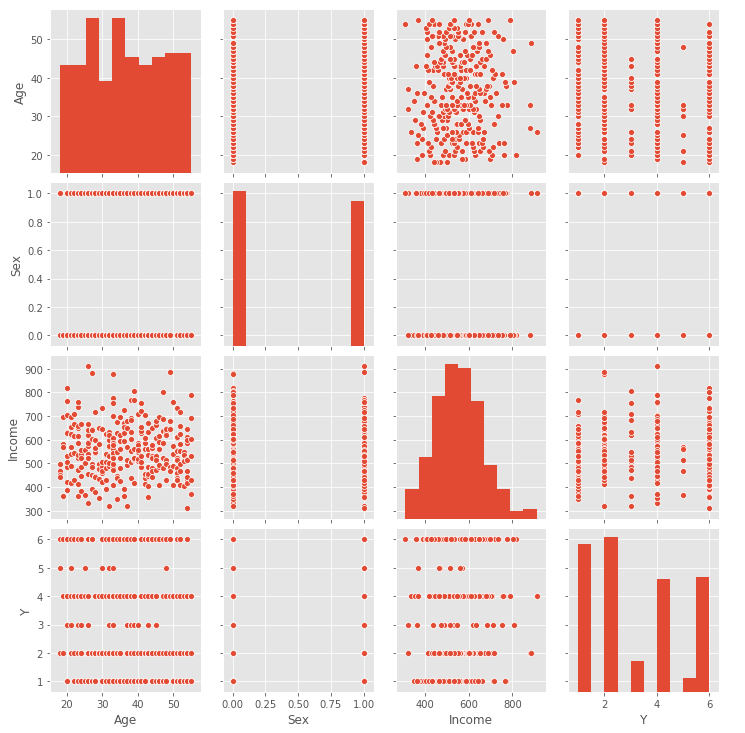

In [3]:
sns.pairplot(data)

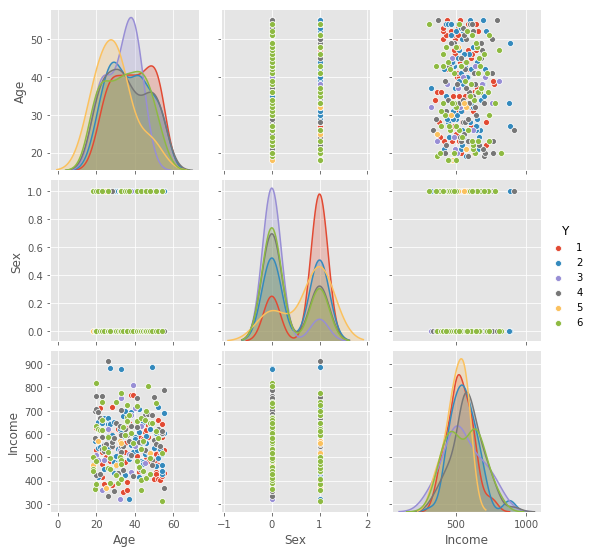

In [4]:
sns.pairplot(data, hue='Y')

In [50]:
data.groupby('Y').mean()

,Age,Sex,Income
Y,,,
1,38.961039,0.766234,531.623377
2,36.913580,0.493827,561.827160
3,33.187500,0.125000,554.812500
4,35.932203,0.338983,583.677966
5,29.571429,0.714286,502.285714
6,34.900000,0.316667,559.616667


In [33]:
stan_model = """

data {
  int N;
  int D;
  int K;
  matrix[N, D] X;
  int<lower=1, upper=K> Y[N];
}

transformed data {
  vector[D] Zeros;
  Zeros = rep_vector(0, D);
}

parameters {
  matrix[D, K-1] b_raw;
}

transformed parameters {
  matrix[D, K] b;
  matrix[N, K] mu;
  matrix[N, K] theta;
  b = append_col(Zeros, b_raw);
  mu = X * b;
}

model {
  for (n in 1:N){
    Y[n] ~ categorical_logit(mu[n,]');
  }
}

generated quantities {
  real y_pred[N];
  for (n in 1:N){
    y_pred[n] = categorical_rng(softmax(mu[n,]'));
  }
}

"""

In [34]:
sm = pystan.StanModel(model_code=stan_model)

ValueError: Failed to parse Stan model 'anon_model_1f3d9610dbb12f9e5fa0a5f5373f7efb'. Error message:
SYNTAX ERROR, MESSAGE(S) FROM PARSER:
No matches for: 

  softmax(matrix)

Available argument signatures for softmax:

  softmax(vector)

 error in 'unknown file name' at line 26, column 21
  -------------------------------------------------
    24:   b = append_col(Zeros, b_raw);
    25:   mu = X * b;
    26:   theta = softmax(mu);
                            ^
    27: }
  -------------------------------------------------



In [7]:
stan_data = {}
stan_data['N'] = data.shape[0]
stan_data['D'] = data.shape[1]
stan_data['K'] = len(data['Y'].unique())
intercept = pd.DataFrame({'intercept': np.ones(data.shape[0])})
stan_data['X'] = pd.concat([intercept, data['Age'], data['Sex'], data['Income']], axis=1)
stan_data['Y'] = data['Y']

In [8]:
fit = sm.sampling(stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [9]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_03a5f5505099d49738ef0d22b86e28a7.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
b_raw[1,1]   -0.18    0.02   1.08   -2.25    -0.9   -0.19    0.54   1.97   1924    1.0
b_raw[2,1]   -0.02  3.6e-4   0.02   -0.05   -0.03   -0.02 -4.7e-3   0.02   1893    1.0
b_raw[3,1]   -1.21  7.4e-3   0.36   -1.92   -1.45   -1.21   -0.97  -0.52   2348    1.0
b_raw[4,1]  2.9e-3  2.9e-5 1.6e-3 -9.8e-5  1.8e-3  2.9e-3  4.0e-3 6.1e-3   2962    1.0
b_raw[1,2]    0.16    0.04   1.79   -3.41   -1.05    0.17    1.38   3.68   1887    1.0
b_raw[2,2]   -0.05  6.3e-4   0.03   -0.11   -0.07   -0.05   -0.03 7.4e-3   2222    1.0
b_raw[3,2]   -3.33    0.02   0.88   -5.27   -3.87   -3.24   -2.71  -1.77   3023    1.0
b_raw[4,2]  2.3e-3  5.1e-5 2.7e-3 -3.1e-3  4.6e-4  2.3e-3  4.0e-3 7.5e-3   

LinAlgError: singular matrix

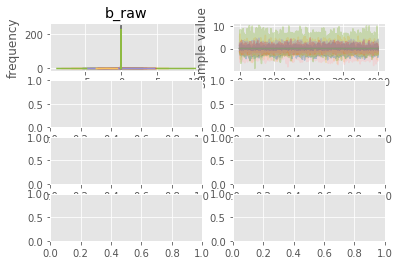

In [10]:
fig = fit.plot()

In [14]:
sample_mu = fit.extract('mu')['mu']

In [18]:
mean_sample_mu = np.mean(sample_mu, axis=0)

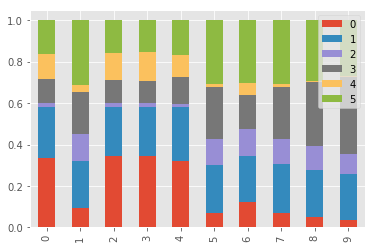

In [47]:
from scipy.special import softmax
pd.DataFrame(softmax(mean_sample_mu, axis=1)[0:10]).plot.bar(stacked=True)

In [51]:
sample_b = fit.extract('b')['b']

In [86]:
sample_b[:,:,1].shape

(4000, 4)

In [55]:
mean_sample_b = np.mean(sample_b, axis=0)

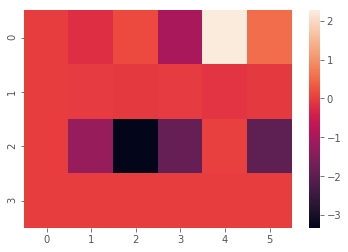

In [61]:
sns.heatmap(mean_sample_b)

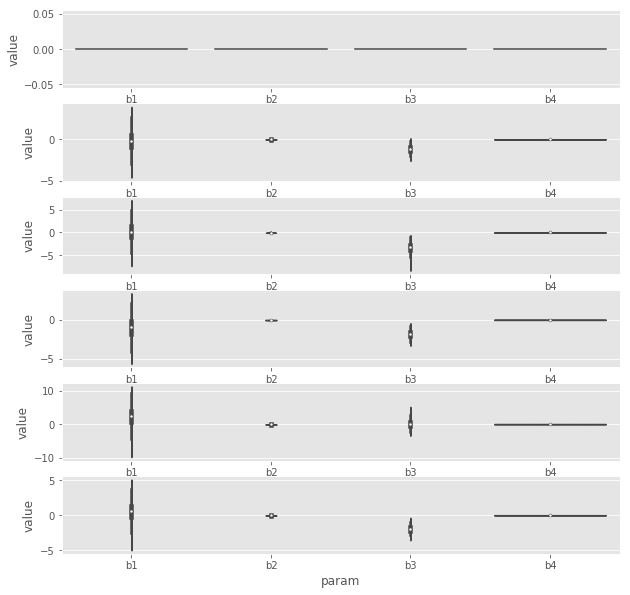

In [89]:
fig, axes = plt.subplots(6, 1, figsize=(10, 10))

for i in range(len(data['Y'].unique())):
    vio_df = pd.concat([
        pd.DataFrame({'param':'b1', 'value':sample_b[:,0,i]}),
        pd.DataFrame({'param':'b2', 'value':sample_b[:,1,i]}),
        pd.DataFrame({'param':'b3', 'value':sample_b[:,2,i]}),
        pd.DataFrame({'param':'b4', 'value':sample_b[:,3,i]})
    ])

    sns.violinplot(data=vio_df, x='param', y='value', ax=axes[i])